![HSV-AI Logo](https://hsv.ai/wp-content/uploads/2022/03/logo_v11_2022.png)

# Implicit Recommendation from ECommerce Data


## Basics of EDA

Here are a few things that we are looking for in the invoice / transaction data:

1. Were there any negative totals? If so why?
2. What percentage of the purchases actually contained multiple items?
3. What is the spread of purchases by customer ID? Do we have a few customers whose behavior may drive recommendations in a way that doesn't fit the average customer?
4. Where there any purchases that were VERY large? If so why? Do we want to include these values to train model behavior?
5. Is there any missing data that we need to scrub?


In [ ]:
%reload_kedro

In [1]:
import pandas as pd
import numpy as np
import random
import scipy.sparse
from matplotlib import pyplot as plt
from pandas.api.types import CategoricalDtype


# Available Files

Let's go ahead and look into some of these files and see what we can see.

In [2]:
events = catalog.load("retailrocket_kaggle_event_data")

2022-03-28 23:07:48,224 - kedro.io.data_catalog - INFO - Loading data from `retailrocket_kaggle_event_data` (CSVDataSet)...


In [3]:
transactions = events[events.event == "transaction"].copy()

# Checking for missing data

In [4]:
print('Total length is',len(transactions))
transactions.isna().sum()

Total length is 22457


timestamp        0
visitorid        0
event            0
itemid           0
transactionid    0
dtype: int64

In [5]:
transactions['order_id'] = transactions.transactionid.astype(str)
transactions['customer_id'] = transactions.visitorid.astype(str)
transactions['product_id'] = transactions.itemid.astype(str)
transactions.head()

,timestamp,visitorid,event,itemid,transactionid,order_id,customer_id,product_id
130,1433222276276,599528,transaction,356475,4000.0,4000.0,599528,356475
304,1433193500981,121688,transaction,15335,11117.0,11117.0,121688,15335
418,1433193915008,552148,transaction,81345,5444.0,5444.0,552148,81345
814,1433176736375,102019,transaction,150318,13556.0,13556.0,102019,150318
843,1433174518180,189384,transaction,310791,7244.0,7244.0,189384,310791


There are 17672 unique transactions

Here are the counts of transactions ordered from largest to smallest
[31 28 27 ...  1  1  1]

And a graph of what the curve looks like:


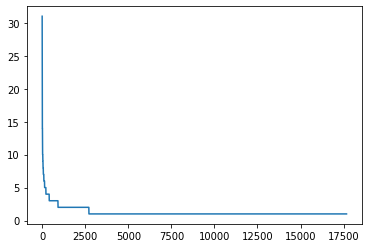

In [6]:
transaction_counts = transactions['order_id'].value_counts().to_numpy()
print('There are', len(transaction_counts), 'unique transactions\n')
print('Here are the counts of transactions ordered from largest to smallest')
print(transaction_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(transaction_counts) 
plt.show()

# User Interactions

Let's take a look at how many unique customers are included in this dataset

There are 11719 unique customers

Here are the counts of transactions per customer ordered from largest to smallest
[559 349 286 ...   1   1   1]

And a graph of what the curve looks like:


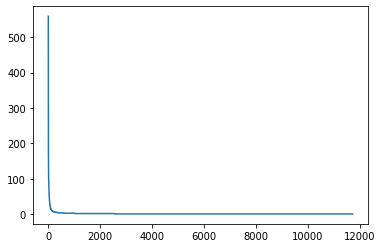

In [7]:
user_counts = transactions['customer_id'].value_counts().to_numpy()
print('There are', len(user_counts), 'unique customers\n')
print('Here are the counts of transactions per customer ordered from largest to smallest')
print(user_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(user_counts) 
plt.show()

In [8]:
transactions.groupby(['customer_id'])['customer_id'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(10)

,customer_id,count
1433,1150086,559
3956,152963,349
7373,530559,286
8814,684514,189
10432,861299,188
9556,76757,185
3643,138131,173
10714,890980,145
2826,1297062,136
4825,247235,132


It looks like "-1" is used when the customer is unknown. Let's take a look at the UserId with the very high count of items in the transactions.

In [9]:
transactions[transactions.customer_id == "1150086"].groupby(transactions.order_id).count()

,timestamp,visitorid,event,itemid,transactionid,order_id,customer_id,product_id
order_id,,,,,,,,
1.0,1,1,1,1,1,1,1,1
1002.0,1,1,1,1,1,1,1,1
10151.0,1,1,1,1,1,1,1,1
10196.0,2,2,2,2,2,2,2,2
1020.0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
9628.0,1,1,1,1,1,1,1,1
9634.0,1,1,1,1,1,1,1,1
9846.0,1,1,1,1,1,1,1,1


It appears that there are a lot of different transactions, so probably not just the same thing being purchased over and over. Not really sure what to do with this at the moment.

# Transactions over Time

Now we need to look at the number of items purchased each day to see if there is anything interesting that pops out.

In [10]:
from datetime import datetime

datetime_object = datetime.fromtimestamp(1433193500981 / 1000.0)


In [11]:
from datetime import datetime

def func(date):
    temp = datetime.fromtimestamp(date / 1000.0)
    return temp.strftime('%Y%m%d')

transactions['datetime'] = transactions.apply(lambda x: func(x.timestamp), axis=1)


<AxesSubplot:>

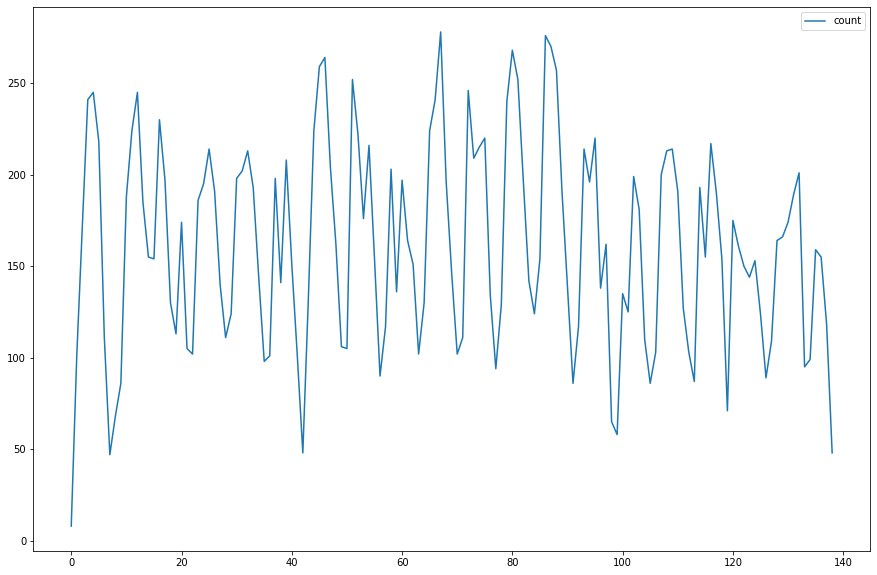

In [12]:
transactions.groupby(['datetime'])['datetime'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['datetime'], ascending=True) \
                             .plot(figsize=(15,10))

In [13]:
minimum_order_size = 2
order_group = transactions.loc[:, ['order_id', 'product_id']].groupby('order_id').count()
 
multi_order = order_group[(order_group.product_id >= minimum_order_size)].count()
single_order = order_group[(order_group.product_id < minimum_order_size)].count()
 
print('Orders with at least',minimum_order_size,'products:',multi_order['product_id'])
print('Orders with less than',minimum_order_size,'products:',single_order['product_id'])
 
# We can capture the list of mutiple product orders with this:
order_filter = order_group[(order_group.product_id >= minimum_order_size)].index.tolist()

filtered_df = transactions[transactions['order_id'].isin(order_filter)].copy()

print('Original dataframe length:', len(transactions))
print('Filtered dataframe length:', len(filtered_df))

filtered_df['quantity'] = 1

Orders with at least 2 products: 2710
Orders with less than 2 products: 14962
Original dataframe length: 22457
Filtered dataframe length: 7495


Well it looks like this entire dataset has transactions with multiple products. No need to filter out transactions with only a single.

# Data Sparcity

Let's take a look at the sparcity of the data. This will tell us how many products were purchased across multiple orders. This is directly related to how well a recommendation system can be trained.

In [14]:
transaction_list = list(np.sort(filtered_df.order_id.unique())) # Get our unique customers
item_list = list(filtered_df.product_id.unique()) # Get our unique products that were purchased
quantity_list = list(filtered_df.quantity) # All of our purchases

cols = filtered_df.order_id.astype(CategoricalDtype(categories=transaction_list, ordered=True)).cat.codes 
# Get the associated row indices
rows = filtered_df.product_id.astype(CategoricalDtype(categories=item_list, ordered=True)).cat.codes 
# Get the associated column indices
purchases_sparse = scipy.sparse.csr_matrix((quantity_list, (rows, cols)), shape=(len(item_list), len(transaction_list)))

In [15]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.9471343681907

In [ ]:
plt.figure(figsize=(15, 15))
plt.spy(purchases_sparse, markersize=1, aspect='auto')

# Storing Interim Data

Now that we have the data cleaned up a bit and formatted correctly, we can save it to an interim file to be picked up by the model training algorithm.

In [ ]:

catalog.save("retail_rocket_transactions", filtered_df[["order_id", "product_id", "price", "quantity"]])